<a href="https://colab.research.google.com/github/TechRoC/Used_Car_Price_Prediction/blob/main/Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
filename = 'cars_price.csv' # Filename
path = '/content/drive/My Drive/' #Drive path
 
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
 
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
import warnings
 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
"""Load DataFrame"""
 
df=pd.read_csv(os.path.join(path,filename))
df = df.drop('Unnamed: 0',axis=1)
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [ ]:
df.info() #checking data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make                 40000 non-null  object 
 1   model                40000 non-null  object 
 2   priceUSD             40000 non-null  int64  
 3   year                 40000 non-null  int64  
 4   condition            40000 non-null  object 
 5   mileage(kilometers)  40000 non-null  float64
 6   fuel_type            40000 non-null  object 
 7   volume(cm3)          39970 non-null  float64
 8   color                40000 non-null  object 
 9   transmission         40000 non-null  object 
 10  drive_unit           38655 non-null  object 
 11  segment              36245 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB


In [ ]:
 
# Separate numerical and column name in list.
object_col = []
num_col = []
all_col = list(df.columns)
for i in all_col:
  if df[i].dtype == 'object':
    object_col.append(i)
  else:
    num_col.append(i)
print("object columns : ", object_col)
print("int/float columns : ", num_col)

object columns :  ['make', 'model', 'condition', 'fuel_type', 'color', 'transmission', 'drive_unit', 'segment']
int/float columns :  ['priceUSD', 'year', 'mileage(kilometers)', 'volume(cm3)']


# **Missing Value Treatment**

In [ ]:
data = df.copy()
 
data.isnull().sum() #return series of columns with respective of number of null values

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit             1345
segment                3755
dtype: int64

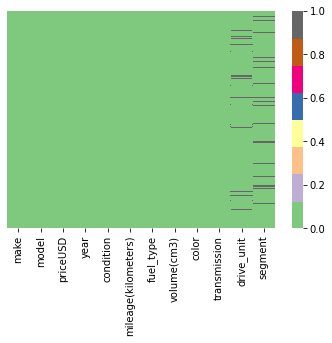

In [ ]:
#heatmap to identify nulll values using graph
sns.heatmap(data.isnull(),yticklabels=False,cbar=True,cmap='Accent')


In [ ]:
check_imputer=data.copy()
 
#object of LabelEncoder
encoder=preprocessing.LabelEncoder()
 
#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data
 
#loop to label each column or categorical values into numberic
for i in tqdm(range(len(object_col))):
    encode(check_imputer[object_col[i]])

100%|██████████| 8/8 [00:00<00:00, 80.80it/s]


In [ ]:
check_imputer.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,32,165,565,1993,2,960015.0,2,2000.0,0,1,1,3
1,24,423,5550,2008,2,172000.0,0,1400.0,10,1,1,7
2,58,853,8300,2008,2,223000.0,2,2500.0,8,0,1,3
3,87,417,3300,2005,2,140000.0,2,1200.0,1,1,1,0
4,58,683,2450,2002,1,413000.0,0,2200.0,3,1,1,3


In [ ]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy=strategy),br_estimator)
    score_simple_imputer[strategy] = cross_val_score(estimator, X, y, scoring='neg_mean_squared_error',cv=N_SPLITS)
    

In [ ]:

# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


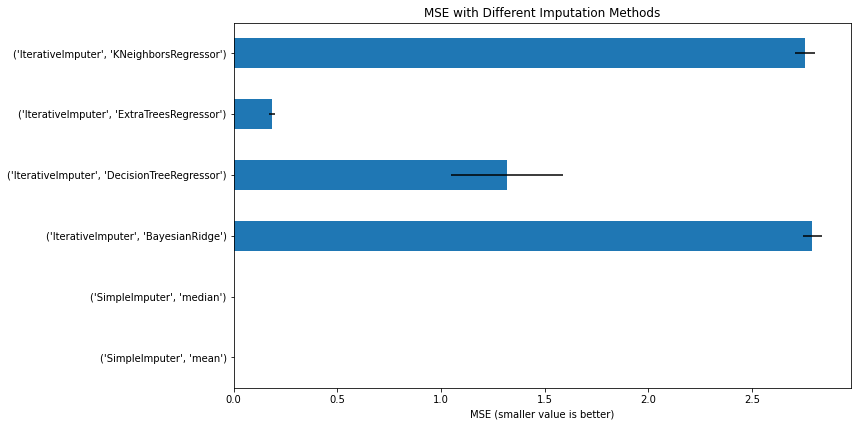

In [ ]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

In [ ]:
data_cat=data[object_col]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in object_col:
    encode(data_cat[columns])
    imputer = IterativeImputer(ExtraTreesRegressor(n_estimators=10, random_state=0)) # ExtraTreesRegressor
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
data[object_col]=data_cat

In [ ]:
data_num=data[num_col]
imputer_num=IterativeImputer(estimators[2]) #estimators[2] = ExtraTreesRegressor
impute_data=imputer_num.fit_transform(data_num)
data[num_col]=impute_data

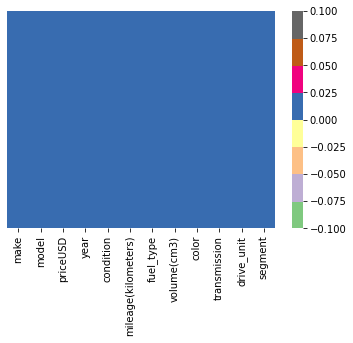

In [ ]:
#Heat map tp check numm values visually
sns.heatmap(data.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [ ]:
data.isnull().sum()

make                   0
model                  0
priceUSD               0
year                   0
condition              0
mileage(kilometers)    0
fuel_type              0
volume(cm3)            0
color                  0
transmission           0
drive_unit             0
segment                0
dtype: int64

In [ ]:
data.to_csv('Cleaned_cars_data',index=False)

# **Data Visalization**


In [ ]:
cleaned_data = pd.read_csv(os.path.join('/content/','Cleaned_cars_data'))# Retriving Data without missing value.

In [ ]:
cleaned_data.head() #observe Data

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565.0,1993.0,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550.0,2008.0,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300.0,2008.0,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300.0,2005.0,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450.0,2002.0,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [ ]:
#cleaned_data['volume(cm3)'].value_counts()

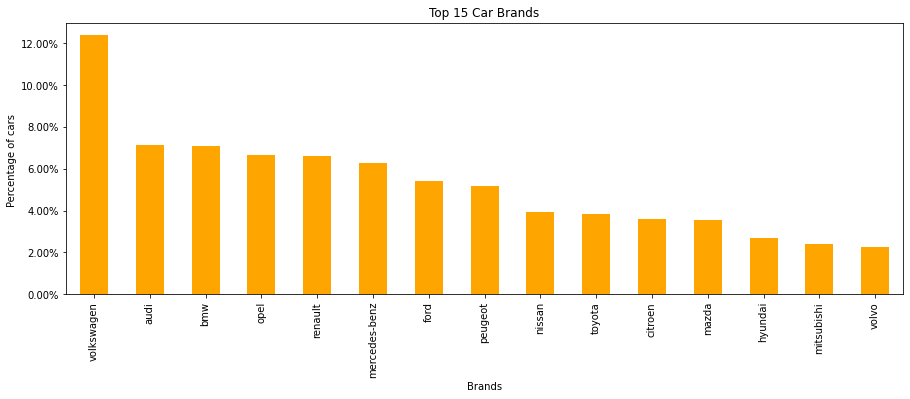

In [ ]:
'''
Top 15 cars brand name that was most
frequently used.
 
'''
 
plt.figure(figsize=(15,5))
ax = cleaned_data['make'].value_counts(normalize = True).head(15).plot(kind='bar', color = 'orange')
plt.title('Top 15 Car Brands')
plt.xlabel('Brands')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

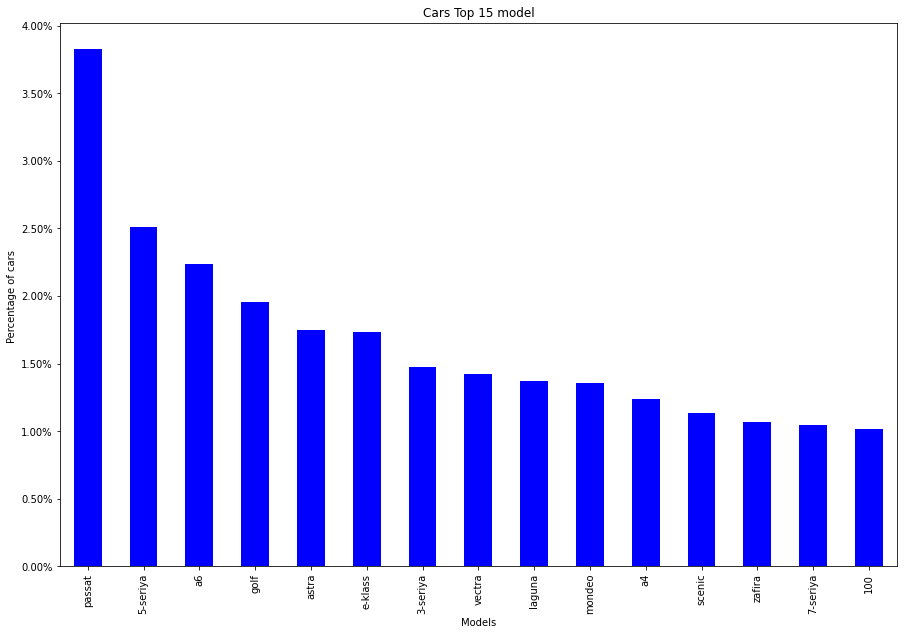

In [ ]:

''' 
Top 15 models of the brand's which was used most frequently
'''
plt.figure(figsize=(15,10))
ax = cleaned_data['model'].value_counts(normalize = True).head(15).plot(kind='bar', color = 'blue')
plt.title('Cars Top 15 model')
plt.xlabel('Models')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Text(0.5, 1.0, 'Number of cars by segment')

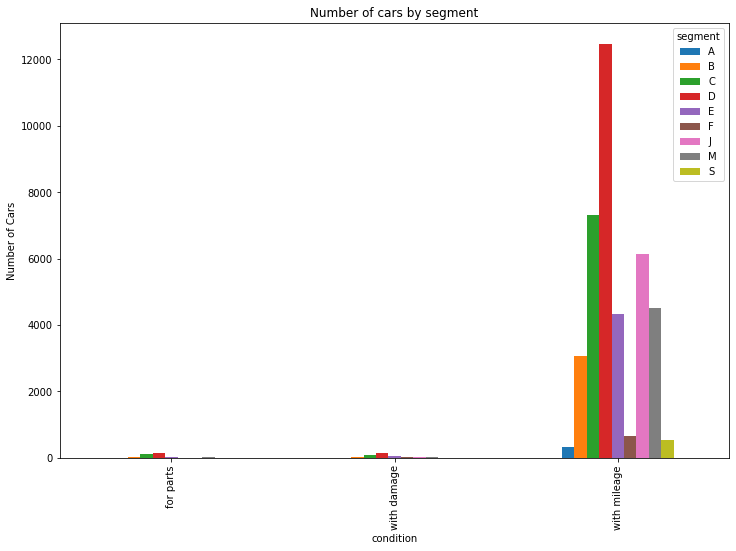

In [ ]:
 
'''
 The condition of the cars come with mileage.
'''
ax = cleaned_data.groupby(['condition', 'segment']).priceUSD.count().unstack().plot(kind = 'bar',figsize = (12,8) )
plt.ylabel("Number of Cars")
plt.xlabel("condition")
plt.title('Number of cars by segment')

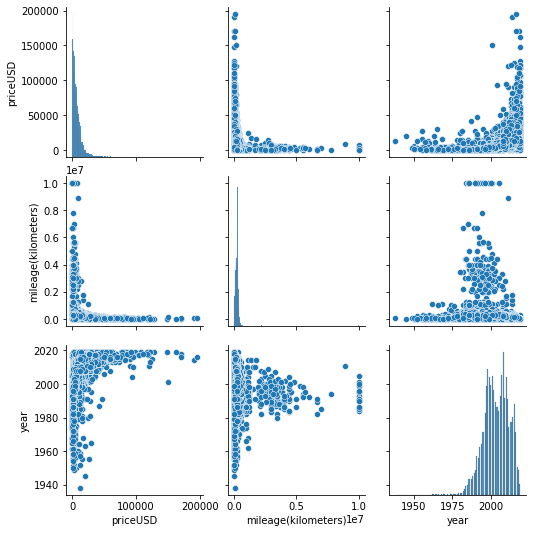

In [ ]:

'''
Car usage is more in late 19s and early 20s and price 
is increasing as the year is increasing.
'''
sns.pairplot(cleaned_data[['priceUSD','mileage(kilometers)','year']])

In [ ]:
'''
Most car runs on petrol and diesel. On early 20s, electrocars are also started to use
'''

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.figure(figsize=(15,5))
x = cleaned_data.year.values
ys = cleaned_data.priceUSD.values
print(len(x),len(ys))
fuel = cleaned_data.fuel_type.values
colors = {'petrol':'red','diesel':'orange','electrocar':'green',}
i = 0
for y, c in zip(ys, fuel):
    plt.scatter(x[i], y, color=colors[c])
    print(i)
    i += 1
plt.savefig('price-fuel-year.png')
plt.xlabel('Year')
plt.ylabel('Price in USD')
plt.legend(colors.keys())
plt.savefig('price-fuel-year.PNG')

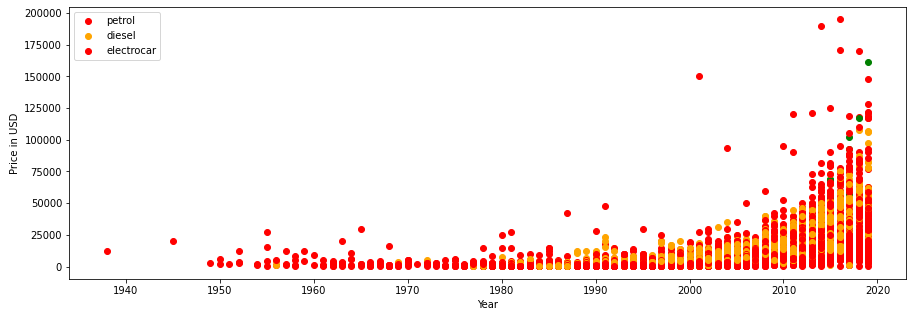

In [ ]:
from IPython.display import Image
Image('/content/price-fuel-year.PNG')

# **Hypothesis Testing**

1.   **chi-Square Test**

     *To check whether there is significant relationship between two varibles segment and transmission.*

In [ ]:
from scipy import stats
dataset_table=pd.crosstab(cleaned_data['segment'],cleaned_data['transmission'])
print(dataset_table)
print('-'*50)

#Observed Values
Observed_Values = dataset_table.values 
print("Observed Values :-\n",Observed_Values)
print('-'*50)
val=stats.chi2_contingency(dataset_table)
print('chi2_contingency',val)
print('-'*50)
Expected_Values=val[3]

no_of_rows=len(dataset_table.iloc[0:2,0])
no_of_columns=len(dataset_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
print('-'*50)
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)]) #chi square formula
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
print('-'*50)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)
print('-'*50)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('p-value:',p_value)
print('-'*50)


if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

transmission  auto  mechanics
segment                      
A               84        248
B              478       2650
C             1611       5898
D             3979       8761
E             1892       2499
F              631         27
J             4420       1741
M              760       3772
S              515         34
--------------------------------------------------
Observed Values :-
 [[  84  248]
 [ 478 2650]
 [1611 5898]
 [3979 8761]
 [1892 2499]
 [ 631   27]
 [4420 1741]
 [ 760 3772]
 [ 515   34]]
--------------------------------------------------
chi2_contingency (7481.260450871147, 0.0, 8, array([[ 119.271  ,  212.729  ],
       [1123.734  , 2004.266  ],
       [2697.60825, 4811.39175],
       [4576.845  , 8163.155  ],
       [1577.46675, 2813.53325],
       [ 236.3865 ,  421.6135 ],
       [2213.33925, 3947.66075],
       [1628.121  , 2903.879  ],
       [ 197.22825,  351.77175]]))
--------------------------------------------------
Degree of Freedom:- 1
-------------



**2.   T-test**
        *To checker whether there is siqnigicant difference between mean of petrol's and diesel's prices.*


     

In [ ]:
 from scipy.stats import ttest_ind
# Null Hypothesis - H0: Mean price of diesel is equal to the mean price of petrol
# Alternative Hypothesis - H1: Mean price of diesel is different than the mean price of petrol

diesel = cleaned_data[cleaned_data.fuel_type == 'diesel'].priceUSD
petrol = cleaned_data[cleaned_data.fuel_type == 'petrol'].priceUSD

statistics,pval = ttest_ind(diesel, petrol)
print(statistics,pval)
if pval < 0.05:
  print("H0 is rejected")
else:
  print("H0 is accepted")
# Ttest_indResult(statistic=181.92229245543183, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# Mean price of diesel is different than the mean price of gas

20.49631573375047 6.986510108373176e-93
H0 is rejected




**3.   Annova two way testing**
      *To check the signification relation between price and affiliated groupby segment.*


In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
# Null Hypothesis: There is significant relation
# Alt-Hypothesis: There is no significant relation between price and segment. 


model = ols('priceUSD ~ transmission',data=cleaned_data).fit()
annova = sm.stats.anova_lm(model,type=2)
annova


# p-value = 0
# F-stat = 10147.157098
# Reject Null Hypothesis
# There is a significant relation between price and segment.

,df,sum_sq,mean_sq,F,PR(>F)
transmission,1.0,5.627474e+11,5.627474e+11,10147.157098,0.0
Residual,39998.0,2.218234e+12,5.545863e+07,NaN,NaN


# **Data Preprocessing**

In [ ]:

''' applying z-score to remove outlier on all numeric columns'''
data1 = cleaned_data[cleaned_data[num_col].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [ ]:
data1.shape

(38629, 12)

In [ ]:
val = dict(data1['model'].value_counts())# frequency count of the column

In [ ]:
 
''' keep track of values whose frequency count 
is more than or equal to 100 for the 
column name model'''
model_col = []
for a,b in val.items():
  if b >= 100:
    model_col.append(a)

In [ ]:

''' filter out the data by only considering the rows having the model count greater or equal to 100'''
data =data1[data1['model'].isin(model_col)]
print(data.shape)
''' remove the row enteries that have fuel type electrocar as it's occurrence is very less.'''
data = data[data['fuel_type'] != 'electrocar']

(24598, 12)


In [ ]:
 
# Applying ranking label encoding 
data['segment'] = data['segment'].map({"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"J":7,"M":8,"S":9})

#Count Frequency encoding on columns whose unique feature count > 10
model_col = dict(data['model'].value_counts())
data['model'] = data['model'].map(model_col)
make_col = dict(data['make'].value_counts()) 
data['make'] = data['make'].map(make_col)
color_col = dict(data['color'].value_counts()) 
data['color'] = data['color'].map(color_col)

In [ ]:
 
#Onehot  encoding of the data by considering dummy variable trap, N-1 columns are taken into account.
new_data = pd.get_dummies(data,drop_first=True)

In [ ]:
new_data # data after onehot encoded

,make,model,priceUSD,year,mileage(kilometers),volume(cm3),color,segment,condition_with damage,condition_with mileage,fuel_type_petrol,transmission_mechanics,drive_unit_front-wheel drive,drive_unit_part-time four-wheel drive,drive_unit_rear drive
0,405,196,565.0,1993.0,960015.0,2000.0,5468,4,0,1,1,1,1,0,0
4,888,323,2450.0,2002.0,413000.0,2200.0,869,4,1,0,0,1,1,0,0
5,888,163,18900.0,2016.0,148000.0,1600.0,5468,7,0,1,0,1,1,0,0
6,495,137,2000.0,1997.0,378194.9,2000.0,1621,4,0,1,1,0,1,0,0
7,4413,777,5950.0,2002.0,245000.0,1900.0,1621,3,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39990,415,126,14990.0,2014.0,134000.0,1600.0,2078,4,0,1,1,0,1,0,0
39991,786,175,2100.0,1999.0,235000.0,1400.0,869,3,0,1,1,1,1,0,0
39992,2368,182,15250.0,2009.0,270000.0,3000.0,5468,6,0,1,0,0,0,0,0
39994,2368,494,9700.0,2008.0,278000.0,2000.0,3809,4,0,1,0,1,1,0,0


In [ ]:
joblib.dump(new_data,'/content/drive/My Drive/cars_onehot_data1.pkl') # save the data

['/content/drive/My Drive/cars_onehot_data1.pkl']